<a href="https://colab.research.google.com/github/ImmortalizedInHearts/NeuralNetwork/blob/main/123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

from tqdm import tqdm

In [8]:
mat = scipy.io.loadmat('data.mat')
trainInputs = np.array(mat['data']['test'][0][0][0][0][0])
trainTargets = np.array(mat['data']['test'][0][0][0][0][1])

testInputs = np.array(mat['data']['training'][0][0][0][0][0])
testTargets = np.array(mat['data']['training'][0][0][0][0][1])

validationInputs = np.array(mat['data']['validation'][0][0][0][0][1])
validationTargets = np.array(mat['data']['validation'][0][0][0][0][0])

x_train = trainInputs
y_train = trainTargets

x_test = testInputs
y_test = testTargets

In [9]:
def forward(nn, inputs):
    x = inputs
    for l in nn:
        x = l.forward(x)
    return x

def backward(nn, loss, prediction, target, learning_rate):
    error = loss.forward(prediction, target)
    derivative = loss.backward()

    for l in reversed(nn):
        derivative = l.backward(derivative, learning_rate)

    return nn, error

def train(nn, loss, x, y, learning_rate, num_iter):
    losses = []

    for i in tqdm(range(num_iter)):
        p = forward(nn, x)
        nn, error = backward(nn, loss, p, y, learning_rate)
        losses.append(error)
    
    return nn, losses

def accuracy(nn, x, y):
    p = forward(nn, x)
    return np.sum((np.argmax(p, 0) == np.argmax(y, 0))*1)/p.shape[1]*100

In [4]:
class CrossEntropy:
    def forward(self, prediction, targets):
        loss = -np.sum(targets*np.log(prediction))
        self._derivative = -targets/prediction
        return loss
    
    def backward(self):
        return self._derivative

In [5]:
class BaseActivation:
    def forward(self, x):
        return x

    def backward(self, grad):
        return grad


class Sigmoid(BaseActivation):
    def forward(self, x):
        self._y = 1. / (1. + np.exp(-x))
        return self._y

    def backward(self, grad):
        derivative = self._y * (1 - self._y)
        return derivative * grad


class Softmax(BaseActivation):
    def forward(self, x):
        self._y = np.exp(x) / np.exp(x).sum(axis=1) [:,None]
        return self._y

    def backward(self, grad):
        return self._y * (grad - (grad * self._y).sum(axis=1)[:, None])


class Dense:
    def __init__(self, input_size, output_size, activation=BaseActivation()):
        self._activation = activation
        self._input_size = input_size
        self._output_size = output_size
        self._w = np.random.randn(output_size, input_size) * np.sqrt(2/input_size)
        self._b = np.random.randn(output_size, 1)

    def forward(self, x):
        self._x = x
        z = self._w @ x + self._b
        return self._activation.forward(z)

    def backward(self, grad, learning_rate):
        
        dy = self._activation.backward(grad)
        
        dx = self._w.T @ dy
        dw = dy @ self._x.T
        db = np.sum(dy, axis=1).reshape((self._output_size, 1))

        self._w -= learning_rate * dw / self._x.shape[1]
        self._b -= learning_rate * db / self._x.shape[1]
 
        return dx

In [21]:
nn = [Dense(256, 128, Sigmoid()), 
      Dense(128, 10,  Softmax())]

loss = CrossEntropy()

learning_rate = 0.75
num_iter = 2000

nn, losses = train(nn, loss, x_train, y_train, learning_rate, num_iter)



100%|██████████| 2000/2000 [04:56<00:00,  6.74it/s]


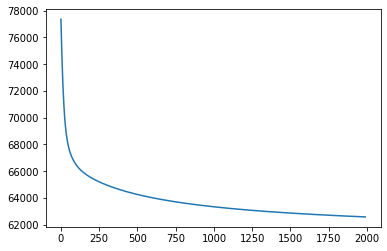

accuracy =  96.2


In [22]:
plt.plot(losses[10:])
plt.show()

print("accuracy = ", accuracy(nn, x_test, y_test))